In [7]:
%reset
import torch
import torch.nn as nn
from torchvision import models
from collections import defaultdict
import torch.nn.functional as F
from utils.loss import dice_loss

from utils.dataloader import *
from utils.ply import *
from utils.models import *

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import alienlab
import numpy as np
import utils.vox_to_coord as vtc
import json
from PIL import Image
import imageio

import glob
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    

torch.cuda.get_device_properties(device).total_memory/1e9
torch.cuda.memory_allocated(device)/1e9

cuda:0


0.94336256

# Image segmentation

### Load model

In [9]:
if True: 
    model = torch.load('trained_model.pt') #needs utils.models imported
    
torch.cuda.memory_allocated(device)/1e9

0.942182912

### Trial images and dataloader

In [10]:
trans_reshape = transforms.Compose([
    #transforms.Resize((448,896)),
    transforms.CenterCrop((896, 448)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

Brec = 2

image_paths = np.sort(glob.glob("data/arabidopsis/test/images/*.png"))
target_paths = np.sort(glob.glob("data/arabidopsis/test/labels/*.png"))

#image_paths = np.sort(glob.glob("reconstruct/*.png"))
#target_paths = np.sort(glob.glob("reconstruct/*.png"))

#image_paths = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/images/*.png"))
#target_paths = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/images/*.png"))

reconstruction_dataset = CustomDataset(image_paths, target_paths, transform = trans_reshape)
reconstruction_loader = torch.utils.data.DataLoader(reconstruction_dataset, batch_size=Brec, shuffle=False, num_workers=1)


gt_dataset = CustomDataset(image_paths, target_paths, transform = trans_reshape)
gt_loader = torch.utils.data.DataLoader(gt_dataset, batch_size=72, shuffle=False, num_workers=1)

print(torch.cuda.memory_allocated(device)/1e9)

0.942182912


In [11]:
# Predict
def evaluate(inputs):

    with torch.no_grad():
        inputs.requires_grad = False
        # Get the first batch
        inputs = inputs.to(device)

        pred = model(inputs)
        # The loss functions include the sigmoid function.
        pred = F.sigmoid(pred)
        
    return pred

model.eval()

pred_tot = []
for inputs, labels in reconstruction_loader:
    pred = evaluate(inputs)
    pred_tot.append(pred) 
    
pred_tot = torch.cat(pred_tot, dim = 0)

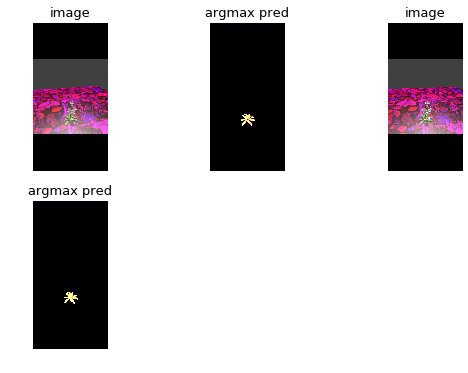

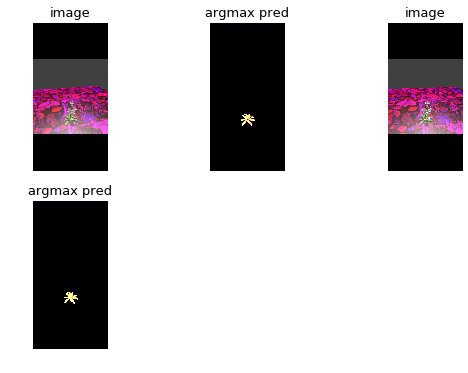

In [12]:
g = alienlab.showclass()

pred = pred.data.cpu().numpy()

# Change channel-order and make 3 channels for matplot
input_images_cpu = [reverse_transform(x) for x in inputs.cpu()]
abels_cpu = labels.cpu().numpy()

# Map each channel (i.e. class) to each color
compare = []
lab = 2
tl = []
for i in range(lab):
    compare.append(input_images_cpu[i])
    tl.append('image')
    compare.append(pred[i,4])
    tl.append('argmax pred')
g.title_list = tl
g.showing(compare)


# Space carving

### Camera parameters

In [13]:
with open('images.json', 'r') as f:
    pose = json.load(f)

N_cam = 72
N_feat = 72

extrinsics = torch.zeros((N_cam, 3, 4))
for i in range(N_cam):
    rot = pose[str(i+1)]['rotmat']
    extrinsics[i][:3,:3] = torch.Tensor(rot)
    trans = pose[str(i+1)]['tvec']
    extrinsics[i][:,3] = torch.Tensor(trans)/10.

with open('cameras.json', 'r') as f:
    focal = json.load(f)
focal = focal['1']['params']

r = 1#1080/448

intrinsics = torch.zeros((1, 3, 3))
intrinsics[:,0,0] = focal[0]*r
intrinsics[:,1,1] = focal[0]*r
intrinsics[:,0,2] = focal[1]*r
intrinsics[:,1,2] = focal[2]*r
intrinsics[:,2,2] = 1

### Voxels

In [14]:
cloud_scale = 1


N = int(65/cloud_scale)
#Voxel representation of the point cloud
min_vec = [int(-40/cloud_scale), int(-40/cloud_scale),int(-5/cloud_scale)] #Limit of the cloud
basis_voxels = vtc.basis_vox(min_vec, N, N, 3*N)#List of coordinates  

### Projection

In [15]:
#Camera projection

torch_voxels = torch.from_numpy(basis_voxels)
#Perspective projection
xy_coords = vtc.project_coordinates(torch_voxels, intrinsics, extrinsics, give_prod = False)

xy_coords[:, 2, :] = xy_coords[:,0,:]
xy_coords[:, 0, :] = xy_coords[:,1,:]
xy_coords[:, 1, :] = xy_coords[:,2,:]

ind = torch_voxels[:,3]==1

#test
#move_camera(torch_voxels, extrinsics, N_cam, prod)  
#local_proj(xy_coords, N_cam, ind)
Sx = 896
Sy = 448
xinit = 1080
yinit = 1920


### Center crop

In [25]:

pred_pad = torch.zeros((N_cam, 6, xinit, yinit))
pred_tot_cop = pred_tot.clone()
pred_tot_cop[:,:,Sx-1,Sy-1] = 0
pred_tot_cop[:,:,0,0] = 0
pred_tot_cop[:,:,Sx-1,0] = 0
pred_tot_cop[:,:,0,Sy-1] = 0
pred_pad[:,:,(xinit-Sx)//2:(xinit+Sx)//2,(yinit-Sy)//2:(yinit+Sy)//2] = pred_tot_cop


# Projection from voxels to images

In [52]:
vol = torch.from_numpy(vtc.basis_vox(min_vec, N, N, 3*N))
coords = xy_coords.clone().int()
maxi = torch.tensor([Sx , Sy])
images_gif = []
for i in range(N_cam):
    coords_i = coords[i].clone()
    ind_0 = coords_i[0,:] >(xinit-Sx)/2
    #print(np.count_nonzero(ind_0))
    #coords_i = coords[i][:, ind_0]
    ind_1 = coords_i[1,:] >(yinit-Sy)/2
    #print(np.count_nonzero(ind_1*ind_0))
    #coords_i = coords_i[:, ind_1]
    ind_2 = coords_i[0,:] < (xinit+Sx)/2
    #print(np.count_nonzero(ind_1*ind_0*ind_2))
    #coords_i = coords_i[:, ind_2]
    ind_3 = coords_i[1,:] < (yinit+Sy)/2
    #print(np.count_nonzero(ind_1*ind_0*ind_2*ind_3))
    #coords_i = coords_i[:, ind_3]            
    ind_tot = ind_0 * ind_1 * ind_2 * ind_3
    coords_i = coords_i[:,ind_tot]
    im = pred_pad[i,4].type(torch.DoubleTensor)
    pix_i = coords_i.type(torch.LongTensor)
    vol[ind_tot,3] += im[pix_i[0], pix_i[1]]
    
    #im_gif = np.zeros((1080, 1920))
    #mask = im < 0.5
    #im_gif[coords_i[0], coords_i[1]] = 1
    #im_gif = im_gif * (~mask).numpy()
    #images_gif.append(Image.fromarray(im_gif))
    
    #plt.figure()
    #im = torch.zeros((1080,1920))
    #im[coords_i[1], coords_i[0]] = 1
    #plt.imshow(im.numpy())

#imageio.mimsave('cloud_sample_check_proj.gif', images_gif)

points = vol[vol[:,3] > 10, :].numpy()
write_ply('rebuilt_cloud.ply', [points],
  ['x', 'y', 'z', 'label'])

True

In [18]:
points = vol[vol[:,3] > 5, :].numpy()
write_ply('rebuilt_cloud.ply', [points],
  ['x', 'y', 'z', 'label'])

True

In [20]:
vol[ind_tot,3]

tensor([5.1001e-04, 1.0437e-03, 1.0896e-04,  ..., 3.3081e-27, 4.1029e-27,
        1.2098e-26], dtype=torch.float64)

In [24]:
pred_pad[0, 4].min()

tensor(0.)

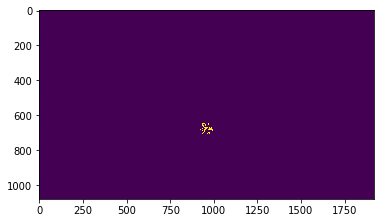

In [47]:
plt.figure()
plt.imshow(images_gif[71]*(~mask).numpy())

tensor(1.)

In [35]:
torch.sum(mask)

tensor(2961)

In [51]:
vol[ind_tot,3].max()

tensor(71.8072, dtype=torch.float64)